In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import wandb
import graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv("../../Data/synthetic_housing_data (Classification).csv")
df.head()

,income,credit_score,house_size,location,property_type,listing_date,realtor_rating,flood_risk,crime_rate,purchase_decision
0,79934.283060,426.0,2148,suburb,Multi-Family,18.4.2023,2.674429,Low,36.504238,not buy
1,67234.713977,313.0,2144,suburb,Townhouse,2019-03-14,2.833726,High,45.847862,buy
2,82953.770762,311.0,1845,downtown,Townhouse,7/26/2019,3.900024,High,50.340274,not buy
3,100460.597128,386.0,1102,rural,Multi-Family,12/28/2020,3.297150,Medium,51.113726,buy
4,65316.932506,823.0,1274,rural,Multi-Family,10.1.2019,3.668849,High,48.209067,buy


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   income             990 non-null    float64
 1   credit_score       995 non-null    float64
 2   house_size         1000 non-null   int64  
 3   location           1000 non-null   object 
 4   property_type      1000 non-null   object 
 5   listing_date       1000 non-null   object 
 6   realtor_rating     995 non-null    float64
 7   flood_risk         999 non-null    object 
 8   crime_rate         1000 non-null   float64
 9   purchase_decision  1000 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 78.3+ KB


In [4]:
df.drop('listing_date', axis=1, inplace=True)

In [5]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_columns)

Categorical columns: ['location', 'property_type', 'flood_risk', 'purchase_decision']


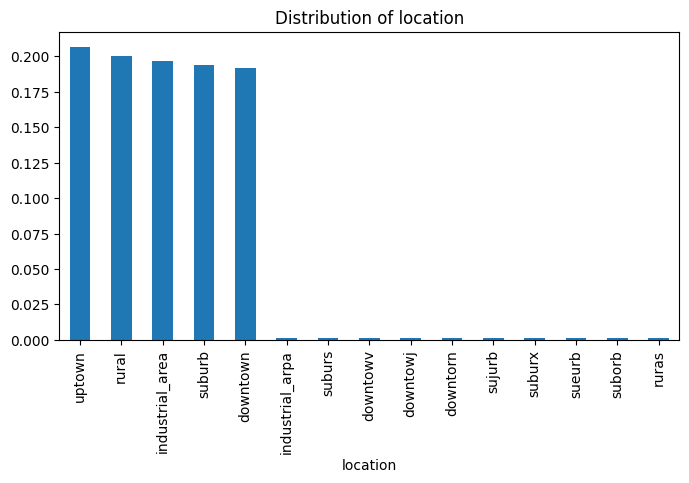

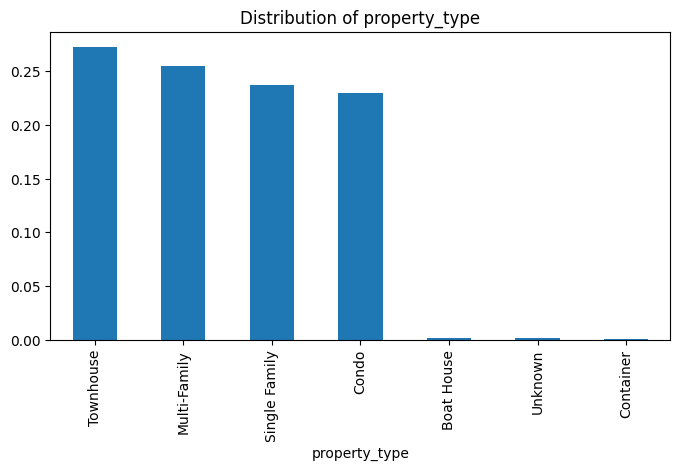

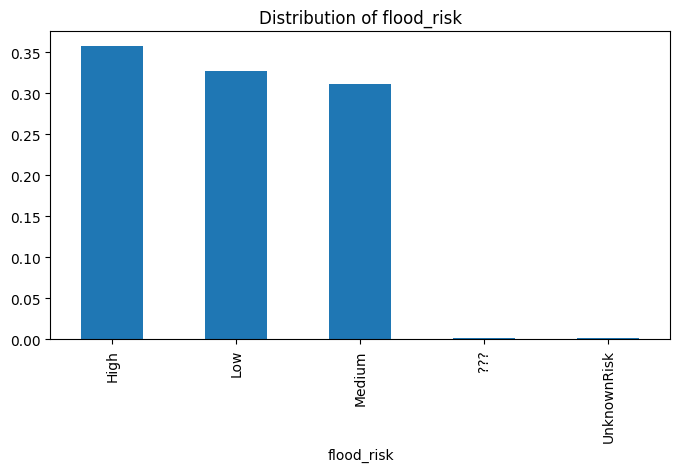

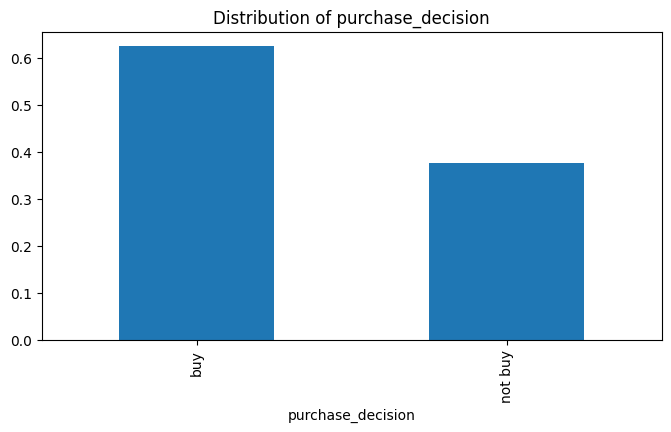

In [6]:
for col in categorical_columns:
    fig = plt.figure(figsize=(8, 4))
    df[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f"Distribution of {col}")
    plt.show()

SMOTE = It is used to balance the class distribution in a dataset by oversampling the minority class.

In [7]:
df['location'].unique()

array(['suburb', 'downtown', 'rural', 'industrial_area', 'uptown',
       'industrial_arpa', 'suburs', 'downtowv', 'downtowj', 'downtorn',
       'sujurb', 'suburx', 'sueurb', 'suborb', 'ruras'], dtype=object)

In [8]:
# Clean up the data
locationReplacementValues = {
    'industrial_arpa': 'industrial_area',
    'suburs': 'suburb',
    'downtowv': 'downtown',
    'downtowj': 'downtown',
    'downtorn': 'downtown',
    'sujurb': 'suburb',
    'San Antonio': 'suburb',
    'suburx': 'suburb',
    'sueurb': 'suburb',
    'suborb': 'suburb',
    'ruras': 'rural'
}
df['location'] = df['location'].replace(locationReplacementValues)
df['location'].unique()

array(['suburb', 'downtown', 'rural', 'industrial_area', 'uptown'],
      dtype=object)

In [9]:
values_to_drop = ['???', 'unknownRisk', 'UnknownRisk']
df.drop(df[df['flood_risk'].isin(values_to_drop)].index, inplace=True)
df.drop(df[df['flood_risk'].isna()].index, inplace=True)

print(df['flood_risk'].unique())

['Low' 'High' 'Medium']


In [10]:
df['property_type'].value_counts(normalize = True)

property_type
Townhouse        0.271357
Multi-Family     0.255276
Single Family    0.238191
Condo            0.230151
Boat House       0.002010
Unknown          0.002010
Container        0.001005
Name: proportion, dtype: float64

In [11]:
propertyTypeReplacementValues = {
    'Container': 'Other',
    'Unknown': 'Other',
    'Boat House': 'Other'
}
df['property_type'] = df['property_type'].replace(propertyTypeReplacementValues)
df['property_type'].unique()

array(['Multi-Family', 'Townhouse', 'Condo', 'Single Family', 'Other'],
      dtype=object)

In [12]:
df.describe()

,income,credit_score,house_size,realtor_rating,crime_rate
count,985.000000,990.000000,995.000000,990.000000,995.000000
mean,73143.272941,581.582828,2014.534673,3.011367,49.855300
std,33643.061319,160.883269,518.010837,1.453354,14.937223
min,5174.653199,300.000000,-97.000000,1.000123,-6.799839
25%,57245.200315,447.000000,1681.500000,1.954739,42.739663
50%,70928.730963,580.000000,2034.000000,2.935646,49.660748
75%,83630.013947,718.750000,2368.500000,3.919604,55.913957
max,459931.000000,1140.000000,3747.000000,19.032236,244.818018


In [13]:
df.describe(include='object')

,location,property_type,flood_risk,purchase_decision
count,995,995,995,995
unique,5,5,3,2
top,uptown,Townhouse,High,buy
freq,207,270,357,620


In [14]:
# Use OHE encoding for categorical variables
df = pd.get_dummies(df, columns=['location', 'property_type', 'flood_risk', 'purchase_decision'], drop_first=True, dtype=int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   income                       985 non-null    float64
 1   credit_score                 990 non-null    float64
 2   house_size                   995 non-null    int64  
 3   realtor_rating               990 non-null    float64
 4   crime_rate                   995 non-null    float64
 5   location_industrial_area     995 non-null    int32  
 6   location_rural               995 non-null    int32  
 7   location_suburb              995 non-null    int32  
 8   location_uptown              995 non-null    int32  
 9   property_type_Multi-Family   995 non-null    int32  
 10  property_type_Other          995 non-null    int32  
 11  property_type_Single Family  995 non-null    int32  
 12  property_type_Townhouse      995 non-null    int32  
 13  flood_risk_Low           

In [15]:
# Use MinMaxScaler to scale the data
minmax_scaler = MinMaxScaler()
df[['income', 'credit_score', 'house_size', 'realtor_rating', 'crime_rate']] = minmax_scaler.fit_transform(df[['income', 'credit_score', 'house_size', 'realtor_rating', 'crime_rate']])
df.head()

,income,credit_score,house_size,realtor_rating,crime_rate,location_industrial_area,location_rural,location_suburb,location_uptown,property_type_Multi-Family,property_type_Other,property_type_Single Family,property_type_Townhouse,flood_risk_Low,flood_risk_Medium,purchase_decision_not buy
0,0.164395,0.150000,0.584027,0.092851,0.172103,0,0,1,0,1,0,0,0,1,0,1
1,0.136469,0.015476,0.582986,0.101685,0.209237,0,0,1,0,0,0,0,1,0,0,0
2,0.171035,0.013095,0.505203,0.160819,0.227091,0,0,0,0,0,0,0,1,0,0,1
3,0.209532,0.102381,0.311915,0.127385,0.230165,0,1,0,0,1,0,0,0,0,1,0
4,0.132252,0.622619,0.356660,0.147999,0.218621,0,1,0,0,1,0,0,0,0,0,0


In [16]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [17]:
# Split the data into features and target variable
X = df.drop(['purchase_decision_not buy'], axis=1)
y = df['purchase_decision_not buy']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [24]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (682, 15)
X_test: (293, 15)


In [25]:
y_train.value_counts(normalize=True)

purchase_decision_not buy
0    0.618768
1    0.381232
Name: proportion, dtype: float64

In [26]:
# Build a Logistic Regression model
lrBase = LogisticRegression(max_iter=1000)
lrBase.fit(X_train, y_train)
y_pred = lrBase.predict(X_test)

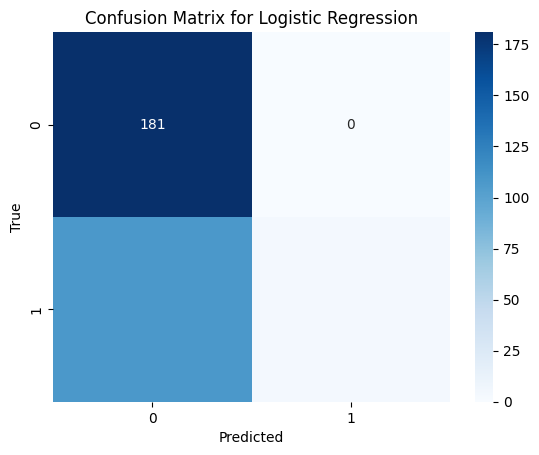

In [27]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Logistic Regression')
plt.show()

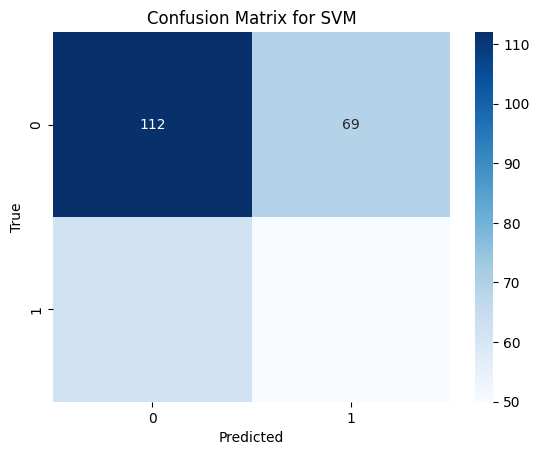

In [33]:
# SVM Model
svmBase = SVC(kernel='sigmoid', C=10, random_state=42)
svmBase.fit(X_train, y_train)
y_pred_svm = svmBase.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for SVM')
plt.show()

In [35]:
y_test.value_counts()

purchase_decision_not buy
0    181
1    112
Name: count, dtype: int64